In [10]:
###################################
## install and import
###################################

In [34]:
# !pip install python-igraph
from notears.locally_connected import LocallyConnected
from notears.lbfgsb_scipy import LBFGSBScipy
from notears.trace_expm import trace_expm
import torch
import torch.nn as nn
import numpy as np
import math
import notears.utils as ut
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import pandas as pd
import os
from pprint import pprint
import matplotlib.pyplot as plt

In [22]:
###################################
## class
###################################

In [23]:
class NotearsMLP(nn.Module):
    def __init__(self, dims, bias=True):
        super(NotearsMLP, self).__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1
        d = dims[0]
        self.dims = dims

        # fc1: variable splitting for l1
        self.fc1_pos = nn.Linear(d, d * dims[1], bias=bias)
        self.fc1_neg = nn.Linear(d, d * dims[1], bias=bias)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()

        # fc2: Locally connected layers with BatchNorm
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers)

    def _bounds(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):
            for m in range(self.dims[1]):
                for i in range(d):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def forward(self, x):  # [n, d] -> [n, d]
        # Apply fc1 and normalize
        x = self.fc1_pos(x) - self.fc1_neg(x)  # [n, d * m1]
        x = x.view(-1, self.dims[0], self.dims[1])  # Reshape to [n, d, m1]

        # Apply fc2 layers and normalization
        for fc in self.fc2:
            x = torch.sigmoid(x)  # Activation
            x = fc(x)  # Locally connected layer output [n, d, m2]

        x = x.squeeze(dim=2)  # [n, d]
        return x

    def h_func(self):
        """Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        h = trace_expm(A) - d  # (Zheng et al. 2018)
        # A different formulation, slightly faster at the cost of numerical stability
        # M = torch.eye(d) + A / d  # (Yu et al. 2019)
        # E = torch.matrix_power(M, d - 1)
        # h = (E.t() * M).sum() - d
        return h

    def l2_reg(self):
        """Take 2-norm-squared of all parameters"""
        reg = 0.
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        reg += torch.sum(fc1_weight ** 2)
        for fc in self.fc2:
            reg += torch.sum(fc.weight ** 2)
        return reg

    def fc1_l1_reg(self):
        """Take l1 norm of fc1 weight"""
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [j * m1, i] -> [i, j]
        """Get W from fc1 weights, take 2-norm over m1 dim"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W

class NotearsMLP2(nn.Module):
    def __init__(self, dims, bias=True):
        super(NotearsMLP2, self).__init__()
        assert len(dims) >= 2
        assert dims[-1] == 1
        d = dims[0]
        self.dims = dims

        # fc1: variable splitting for l1
        self.fc1_pos = nn.Linear(d, d * dims[1], bias=bias)
        self.fc1_neg = nn.Linear(d, d * dims[1], bias=bias)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()

        # Layer normalization after fc1
        self.ln1 = nn.LayerNorm(d * dims[1])  # Normalize across feature dimensions

        # fc2: Locally connected layers with BatchNorm
        layers = []
        for l in range(len(dims) - 2):
            layers.append(LocallyConnected(d, dims[l + 1], dims[l + 2], bias=bias))
        self.fc2 = nn.ModuleList(layers)
        self._apply_bounds()                

    def _bounds(self):
        d = self.dims[0]
        bounds = []
        for j in range(d):
            for m in range(self.dims[1]):
                for i in range(d):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds
    
    def _apply_bounds(self):
        """Clip weights of fc1_pos and fc1_neg to stay within bounds."""
        with torch.no_grad():
            for layer, bounds in [(self.fc1_pos, self.fc1_pos.weight.bounds), (self.fc1_neg, self.fc1_neg.weight.bounds)]:
                # Apply bounds per weight
                for idx, (min_bound, max_bound) in enumerate(bounds):
                    if max_bound is not None:  # Clip only if max_bound is defined
                        layer.weight.data.view(-1)[idx].clamp_(min_bound, max_bound)    

    def forward(self, x):  # [n, d] -> [n, d]
        # Apply fc1 and normalize
        x = self.fc1_pos(x) - self.fc1_neg(x)  # [n, d * m1]
        # self._apply_bounds()  # Enforce bounds on fc1 weights
        x = self.ln1(x)  # Apply LayerNorm after fc1
        x = x.view(-1, self.dims[0], self.dims[1])  # Reshape to [n, d, m1]

        # Apply fc2 layers and normalization
        for fc in self.fc2:
            x = torch.sigmoid(x)  # Activation
            x = fc(x)  # Locally connected layer output [n, d, m2]

        x = x.squeeze(dim=2)  # [n, d]
        return x

    def h_func(self):
        """Constrain 2-norm-squared of fc1 weights along m1 dim to be a DAG"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        h = trace_expm(A) - d  # (Zheng et al. 2018)
        # A different formulation, slightly faster at the cost of numerical stability
        # M = torch.eye(d) + A / d  # (Yu et al. 2019)
        # E = torch.matrix_power(M, d - 1)
        # h = (E.t() * M).sum() - d
        return h

    def l2_reg(self):
        """Take 2-norm-squared of all parameters"""
        reg = 0.
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        reg += torch.sum(fc1_weight ** 2)
        for fc in self.fc2:
            reg += torch.sum(fc.weight ** 2)
        return reg

    def fc1_l1_reg(self):
        """Take l1 norm of fc1 weight"""
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:  # [j * m1, i] -> [i, j]
        """Get W from fc1 weights, take 2-norm over m1 dim"""
        d = self.dims[0]
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j * m1, i]
        fc1_weight = fc1_weight.view(d, -1, d)  # [j, m1, i]
        A = torch.sum(fc1_weight * fc1_weight, dim=1).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W

class NotearsSobolev(nn.Module):
    def __init__(self, d, k):
        """d: num variables k: num expansion of each variable"""
        super(NotearsSobolev, self).__init__()
        self.d, self.k = d, k
        self.fc1_pos = nn.Linear(d * k, d, bias=False)  # ik -> j
        self.fc1_neg = nn.Linear(d * k, d, bias=False)
        self.fc1_pos.weight.bounds = self._bounds()
        self.fc1_neg.weight.bounds = self._bounds()
        nn.init.zeros_(self.fc1_pos.weight)
        nn.init.zeros_(self.fc1_neg.weight)
        self.l2_reg_store = None

    def _bounds(self):
        # weight shape [j, ik]
        bounds = []
        for j in range(self.d):
            for i in range(self.d):
                for _ in range(self.k):
                    if i == j:
                        bound = (0, 0)
                    else:
                        bound = (0, None)
                    bounds.append(bound)
        return bounds

    def sobolev_basis(self, x):  # [n, d] -> [n, dk]
        seq = []
        for kk in range(self.k):
            mu = 2.0 / (2 * kk + 1) / math.pi  # sobolev basis
            psi = mu * torch.sin(x / mu)
            seq.append(psi)  # [n, d] * k
        bases = torch.stack(seq, dim=2)  # [n, d, k]
        bases = bases.view(-1, self.d * self.k)  # [n, dk]
        return bases

    def forward(self, x):  # [n, d] -> [n, d]
        bases = self.sobolev_basis(x)  # [n, dk]
        x = self.fc1_pos(bases) - self.fc1_neg(bases)  # [n, d]
        self.l2_reg_store = torch.sum(x ** 2) / x.shape[0]
        return x

    def h_func(self):
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        h = trace_expm(A) - d  # (Zheng et al. 2018)
        # A different formulation, slightly faster at the cost of numerical stability
        # M = torch.eye(self.d) + A / self.d  # (Yu et al. 2019)
        # E = torch.matrix_power(M, self.d - 1)
        # h = (E.t() * M).sum() - self.d
        return h

    def l2_reg(self):
        reg = self.l2_reg_store
        return reg

    def fc1_l1_reg(self):
        reg = torch.sum(self.fc1_pos.weight + self.fc1_neg.weight)
        return reg

    @torch.no_grad()
    def fc1_to_adj(self) -> np.ndarray:
        fc1_weight = self.fc1_pos.weight - self.fc1_neg.weight  # [j, ik]
        fc1_weight = fc1_weight.view(self.d, self.d, self.k)  # [j, i, k]
        A = torch.sum(fc1_weight * fc1_weight, dim=2).t()  # [i, j]
        W = torch.sqrt(A)  # [i, j]
        W = W.cpu().detach().numpy()  # [i, j]
        return W

In [24]:
###################################
## function
###################################

In [41]:
def squared_loss(output, target):
    n = target.shape[0]
    loss = 0.5 / n * torch.sum((output - target) ** 2)
    return loss

def notears_nonlinear(model: nn.Module,
                      X: np.ndarray,
                      lambda1: float = 0.,
                      lambda2: float = 0.,
                      max_iter: int = 100,
                      h_tol: float = 1e-8,
                      rho_max: float = 1e+16,
                      w_threshold: float = 0.3):
    model.w_threshold = w_threshold
    rho, alpha, h = 1.0, 0.0, np.inf
    for _ in range(max_iter):
        rho, alpha, h = dual_ascent_step(model, X, lambda1, lambda2,
                                         rho, alpha, h, rho_max)
        if h <= h_tol or rho >= rho_max:
            break
    W_est = model.fc1_to_adj()
    W_est[np.abs(W_est) < w_threshold] = 0
    return W_est

def notears_nonlinear_with_loss_std(model: nn.Module,
                                    X_list: list,  
                                    lambda1: float = 0.0,
                                    lambda2: float = 0.0,
                                    max_iter: int = 100,
                                    h_tol: float = 1e-8,
                                    rho_max: float = 1e+16,
                                    w_threshold: float = 0.3,
                                    std_lambda: float = 1.0,
                                    lr: float = 1e-3,
                                    s0: int = 1
                                   ):  
    model.w_threshold = w_threshold    
    rho, alpha, h = 1.0, 0.0, np.inf
    for iter_no in range(max_iter):
        rho, alpha, h = dual_ascent_step_with_loss_std(
            model, X_list, lambda1, lambda2, std_lambda, rho, alpha, h, rho_max, iter_no, lr=lr)
        if h <= h_tol or rho >= rho_max:
            break
    W_est = model.fc1_to_adj()
    # W_est[np.abs(W_est) < w_threshold] = 0
    flat_W = np.abs(W_est).flatten()
    w_threshold = np.partition(flat_W, -s0)[-s0]  # s0-th largest
    mask = np.abs(W_est) < w_threshold
    W_est[mask] = 0
    return W_est

def dual_ascent_step(model, X, lambda1, lambda2, rho, alpha, h, rho_max):
    """Perform one step of dual ascent in augmented Lagrangian."""
    h_new = None
    optimizer = LBFGSBScipy(model.parameters())
    X_torch = torch.from_numpy(X)
    while rho < rho_max:
        def closure():
            optimizer.zero_grad()
            X_hat = model(X_torch)
            loss = squared_loss(X_hat, X_torch)
            h_val = model.h_func()
            penalty = 0.5 * rho * h_val * h_val + alpha * h_val
            l2_reg = 0.5 * lambda2 * model.l2_reg()
            l1_reg = lambda1 * model.fc1_l1_reg()
            primal_obj = loss + penalty + l2_reg + l1_reg
            # primal_obj = loss + penalty
            primal_obj.backward()
            return primal_obj
        optimizer.step(closure)  # NOTE: updates model in-place
        with torch.no_grad():
            h_new = model.h_func().item()
        if h_new > 0.25 * h:
            rho *= 10
        else:
            break
    alpha += rho * h_new
    return rho, alpha, h_new

def dual_ascent_step_with_loss_std(model, X_list, lambda1, lambda2, std_lambda, rho, alpha, h, rho_max, iter_no, lr=0.001):
    """Perform one step of dual ascent in augmented Lagrangian, with consistent gradient-based learning (CGLearn) for each predictor."""

    crp = std_lambda  # Consistency ratio percentile
    h_new = None
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Using Adam optimizer instead of LBFGSBScipy
    # X_tensors = [torch.from_numpy(X).float().to(torch.double).to(model.fc1_pos.weight.device) for X in X_list]  # Ensure tensors are on the correct device
    X_tensors = [torch.from_numpy(X).to(torch.double).to(model.fc1_pos.weight.device) for X in X_list]
    
    while rho < rho_max:
        # print('------------------')                
        # print('iter_no', iter_no)
        # print('W')
        # print(model.fc1_to_adj())
        feature_l2_norms_pos_per_predictor = [[] for _ in range(model.dims[0])]  # Separate L2 norms for fc1_pos
        feature_l2_norms_neg_per_predictor = [[] for _ in range(model.dims[0])]  # Separate L2 norms for fc1_neg
        list_all_grads = []  # To store gradients for the entire model (all layers)

        # Step 1: Compute loss and gradients for each environment
        # print()
        # print()
        # print()
        for X in X_tensors:
            # Loss calculation
            X_hat = model(X)
            loss_mse = squared_loss(X_hat, X)
            h_val = model.h_func()
            penalty = 0.5 * rho * h_val * h_val + alpha * h_val
            l2_reg = 0.5 * lambda2 * model.l2_reg()
            l1_reg = lambda1 * model.fc1_l1_reg()
            final_loss = (loss_mse + penalty + l2_reg + l1_reg) / len(X_tensors)  # Averaged across environments

            # Grad calculation
            optimizer.zero_grad()
            final_loss.backward()

            # Collect all gradients for the entire model (for all layers)
            grads = []
            for param in model.parameters():
                grads.append(param.grad.clone().flatten())
            all_grads = torch.cat(grads)  # Flatten and concatenate all gradients for all parameters
            list_all_grads.append(all_grads)  # Store gradients for this dataset
            
            # print('#######################################################################################################################')
            # print(model.fc1_pos.weight.grad)
            # print('#######################################################################################################################')            

            # Compute and store gradients per predictor for the first hidden layer
            for i in range(model.dims[0]):  # Iterate over each predictor (input feature)
                # Get the gradients for the first hidden layer (fc1_pos and fc1_neg)                
                pos_g = model.fc1_pos.weight.grad.view(model.dims[0], -1, model.dims[0])[i, :, :]  # Shape [5, 10]
                neg_g = model.fc1_neg.weight.grad.view(model.dims[0], -1, model.dims[0])[i, :, :]  # Shape [5, 10]
                                
                # Compute L2 norms of the gradients across the hidden neurons for each feature                
                l2_norms_pos = torch.norm(pos_g, dim=0, p=2).detach()  # L2 norm across hidden neurons, result shape: [10]
                l2_norms_neg = torch.norm(neg_g, dim=0, p=2).detach()  # Same for fc1_neg
                
                # Store L2 norms for each predictor
                feature_l2_norms_pos_per_predictor[i].append(l2_norms_pos)
                feature_l2_norms_neg_per_predictor[i].append(l2_norms_neg)
                
        
        # Step 2: Compute mean of all gradients for the entire model across all datasets
        list_all_grads = torch.stack(list_all_grads)  # Stack all gradients for all datasets
        mean_all_grads = torch.mean(list_all_grads, dim=0)  # Mean gradient for the entire model

        # Step 3: Gradient consistency calculations (CGLearn) per predictor
        consistency_masks_pos = []
        consistency_masks_neg = []
            
        for i in range(model.dims[0]):  # Iterate over each predictor (input feature)            
            feature_l2_norms_pos = torch.stack(feature_l2_norms_pos_per_predictor[i])  # Stack L2 norms across datasets
            mean_norms_pos = torch.mean(feature_l2_norms_pos, dim=0)  # Mean of L2 norms for each feature
            # if i==0:
            #     print('#######################################################################################################################')
            #     print('mean_norms_pos', i)
            #     print(mean_norms_pos)            
            #     print('#######################################################################################################################')                                            
            std_norms_pos = torch.std(feature_l2_norms_pos, dim=0) + 1e-8  # Standard deviation of L2 norms for each feature
            # if i==0:
            #     print('#######################################################################################################################')
            #     print('std_norms_pos', i)
            #     print(std_norms_pos)            
            #     print('#######################################################################################################################')                                            
            cr_pos = torch.abs(mean_norms_pos) / std_norms_pos  # Consistency ratio
            # if i==0:
            #     print('#######################################################################################################################')
            #     print('cr_pos')
            #     print(cr_pos)
            #     print('#######################################################################################################################')                                                       
            cr_pos[i] = 0                
            # if i==0:
            #     print('#######################################################################################################################')
            #     print('cr_pos')
            #     print(cr_pos)
            #     print('#######################################################################################################################')                                                       
            if crp == 101:
                consistency_mask_pos = torch.zeros_like(cr_pos, device=model.fc1_pos.weight.device)
            elif crp == -1:
                a = torch.tensor(cr_pos, dtype=torch.float32)
                b = (a - a.min()) / (a.max() - a.min() + 1e-8)
                consistency_mask_pos = b * (len(b) / b.sum())  # Scale so sum(crp) = len(crp)
            else:
                ct_pos = np.percentile(cr_pos.cpu().numpy(), crp)  # Threshold based on the percentile                
                consistency_mask_pos = torch.where(
                    cr_pos >= ct_pos, 
                    torch.tensor(1., device=model.fc1_pos.weight.device), 
                    torch.tensor(0., device=model.fc1_pos.weight.device)
                )         
            consistency_mask_pos[i] = 0
            consistency_masks_pos.append(consistency_mask_pos.repeat(model.dims[1], 1))  # Broadcast the mask
            
            # Consistency check for fc1_neg weights of predictor i
            feature_l2_norms_neg = torch.stack(feature_l2_norms_neg_per_predictor[i])  # Same for fc1_neg
            mean_norms_neg = torch.mean(feature_l2_norms_neg, dim=0)
            std_norms_neg = torch.std(feature_l2_norms_neg, dim=0) + 1e-8
            cr_neg = torch.abs(mean_norms_neg) / std_norms_neg  # Consistency ratio
            cr_neg[i] = 0
            if crp == 101:
                consistency_mask_neg = torch.zeros_like(cr_neg, device=model.fc1_neg.weight.device)
            elif crp == -1:
                a = torch.tensor(cr_neg, dtype=torch.float32)
                b = (a - a.min()) / (a.max() - a.min() + 1e-8)
                consistency_mask_neg = b * (len(b) / b.sum())  # Scale so sum(crp) = len(crp)
            else:
                ct_neg = np.percentile(cr_neg.cpu().numpy(), crp)
                consistency_mask_neg = torch.where(
                    cr_neg >= ct_neg, 
                    torch.tensor(1., device=model.fc1_neg.weight.device), 
                    torch.tensor(0., device=model.fc1_neg.weight.device)
                )
            consistency_mask_neg[i] = 0                
            consistency_masks_neg.append(consistency_mask_neg.repeat(model.dims[1], 1))

        # Step 4: Apply the masks to gradients before updating parameters
        cmp = torch.stack(consistency_masks_pos).view(-1, model.dims[0]) 
        ## after stack, dim=0 is for target, which is correct cause the list element is for each target     
        cmn = torch.stack(consistency_masks_neg).view(-1, model.dims[0])        
        ## after stack, dim=0 is for target, which is correct cause the list element is for each target     
        ## need to be shaped as [j, m1, i] == [target, interimNeurons, input] as the weights are in the shape [j, m1, i]
        # print('cmp')
        # print(cmp.t())
        model.vis['data'].append((iter_no, model.fc1_to_adj(), cmp.t()))
        start_index = 0
        for name, param in model.named_parameters():
            param_numel = param.numel()
            mean_grad = mean_all_grads[start_index: start_index + param_numel].view_as(param)
            if 'fc1_pos.weight' in name:
                param.grad = mean_grad * cmp       
            elif 'fc1_neg.weight' in name:
                param.grad = mean_grad * cmn    
            else:
                param.grad = mean_grad
            start_index += param_numel

        # Step 5: Now that the gradients have been modified, perform the optimization step
        optimizer.step()
        # model._apply_bounds()        

        # Step 6: Check convergence and adjust rho
        with torch.no_grad():
            h_new = model.h_func().item()
        if h_new > 0.25 * h:
            rho *= 10
        else:
            break
            
        # ww = model.fc1_to_adj()
        # ww[np.abs(ww) < model.w_threshold] = 0
        # print(ww)

    alpha += rho * h_new
    return rho, alpha, h_new


In [42]:
##
## todo1: create small run, monitor, and check the whole process validity
##
exp_id = '08_dNewEnvSmallRun'
directories = ['inputs', 'outputs']
for directory in directories:
    path = os.path.join(directory, exp_id)
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created folder: {path}")
    else:
        print(f"Folder already exists: {path}")

torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)
list_res = []
column_titles = ["ntrials", "sample", "node", "edge", "graph", "SEM", "hiddenU", "l1", "l2", "wthresh", "lr", "cthresh", "fdr", "shd", "tpr", "nnz"]
df = pd.DataFrame(list_res, columns=column_titles)
df.to_csv(f'outputs/{exp_id}/result.csv', index=False, encoding="utf-8-sig")  
##############################################################
########## set parameters for experiments
ntrials = 1
list_opt = [ ## + check number of trials
    (200, 4, 6/4, 'ER', 'mlp', 1, 0, 0, 0.3, 0.1),
]
##############################################################
for opt in list_opt:
    n, d, _s0, graph_type, sem_type, nh, l1, l2, wt, lr = opt
    s0 = int(d*_s0)
    list_fdr0, list_shd0, list_tpr0, list_nnz0 = [], [], [], [] ## notears 
    list_fdr1, list_shd1, list_tpr1, list_nnz1 = [], [], [], [] ## notears + invariance 50%
    list_fdr2, list_shd2, list_tpr2, list_nnz2 = [], [], [], [] ## notears + invariance continuous    
    for tn in range(ntrials):
        ##
        ## initialize
        ##
        ut.set_random_seed(123+tn)
        ###############################################
        ########## Creating Ideal Environments with Different Variation (different noiseScale, different causality)
        # B_true = ut.simulate_dag(d, s0, graph_type)
        # np.savetxt(f'inputs/{exp_id}/W_true.csv', B_true, delimiter=',')
        # raise Exception('exit')
        ##
        ## here perform intervention on W_true and create W_true_0, W_true_1, ..., W_true_4
        ##
        B_true = np.loadtxt(f'inputs/{exp_id}/W_true.csv', delimiter=',')        
        B_true_i_list = []
        for i in range(5):
            B_true_i = np.loadtxt(f'inputs/{exp_id}/W_true_{i}.csv', delimiter=',')
            B_true_i_list.append(B_true_i)
        noise_scales = [0.5, 1.5, 1, 1, 1]
        for i, noise_scale_value in enumerate(noise_scales):
            noise_scale = np.full(d, noise_scale_value)  
            X = ut.simulate_nonlinear_sem(B_true_i_list[i], n, sem_type, noise_scale)
            # X = ut.simulate_linear_sem(B_true_i_list[i], n, 'gauss', noise_scale)            
            np.savetxt(f'inputs/{exp_id}/X_{i}.csv', X, delimiter=',')  
        ###############################################
        ###############################################            
        X_0 = np.loadtxt(f'inputs/{exp_id}/X_0.csv', delimiter=',')
        X_1 = np.loadtxt(f'inputs/{exp_id}/X_1.csv', delimiter=',')
        X_2 = np.loadtxt(f'inputs/{exp_id}/X_2.csv', delimiter=',')
        X_3 = np.loadtxt(f'inputs/{exp_id}/X_3.csv', delimiter=',')
        X_4 = np.loadtxt(f'inputs/{exp_id}/X_4.csv', delimiter=',')
        X_list = [X_0, X_1, X_2, X_3, X_4]  # List of datasets
        scaler = StandardScaler()
        X_list_standardized = [scaler.fit_transform(X) for X in X_list] ## separate fit_transform cause each dataset with different scale (diff noise scale)
        X_combined = np.vstack([X for X in X_list_standardized]) 
        ## inotears
        ## 0
        print('==================================================================================================================================')
        print('Take All')
        print('==================================================================================================================================')        
        # model = NotearsMLP2(dims=[d, nh, 1], bias=True)
        # W_est = notears_nonlinear_with_loss_std(model, X_list_standardized, lambda1=l1, lambda2=l2, std_lambda=0, w_threshold=wt, lr=lr, s0=s0)
        # # assert ut.is_dag(W_est)
        # np.savetxt(f'outputs/{exp_id}/W_est0.csv', W_est, delimiter=',')
        # acc = ut.count_accuracy(B_true, W_est != 0)
        # print('W_est')
        # print(W_est)
        # print('acc', acc)
        # list_fdr0.append(acc['fdr'])
        # list_shd0.append(acc['shd'])
        # list_tpr0.append(acc['tpr'])
        # list_nnz0.append(acc['nnz'])        
        ## 1
        print('==================================================================================================================================')
        print('Take Selective')               
        print('==================================================================================================================================')                
        model = NotearsMLP2(dims=[d, nh, 1], bias=True)
        model.vis = {'B_true': B_true, 'data': []}
        W_est = notears_nonlinear_with_loss_std(model, X_list_standardized, lambda1=l1, lambda2=l2, std_lambda=-1, w_threshold=wt, lr=lr, s0=s0)
        # assert ut.is_dag(W_est)
        np.savetxt(f'outputs/{exp_id}/W_est1.csv', W_est, delimiter=',')
        acc = ut.count_accuracy(B_true, W_est != 0)
        print('B_true')
        print(B_true)
        print('W_est')
        print(W_est)
        print('acc', acc)        
        list_fdr1.append(acc['fdr'])
        list_shd1.append(acc['shd'])
        list_tpr1.append(acc['tpr'])
        list_nnz1.append(acc['nnz'])        
        ## 2
        print('==================================================================================================================================')
        print('Take None')        
        print('==================================================================================================================================')                
        # model = NotearsMLP2(dims=[d, nh, 1], bias=True)
        # W_est = notears_nonlinear_with_loss_std(model, X_list_standardized, lambda1=l1, lambda2=l2, std_lambda=101, w_threshold=wt, lr=lr, s0=s0)
        # # assert ut.is_dag(W_est)
        # np.savetxt(f'outputs/{exp_id}/W_est2.csv', W_est, delimiter=',')
        # acc = ut.count_accuracy(B_true, W_est != 0)
        # print('W_est')
        # print(W_est)
        # print('acc', acc)        
        # list_fdr2.append(acc['fdr'])
        # list_shd2.append(acc['shd'])
        # list_tpr2.append(acc['tpr'])
        # list_nnz2.append(acc['nnz'])        
        
    res = (
        str(ntrials), str(n), str(d), str(s0), str(graph_type), str(sem_type), str(nh), str(l1), str(l2), str(wt), str(lr), str(0), 
        f'{np.mean(list_fdr0):.4f} ± {np.std(list_fdr0):.4f}', f'{np.mean(list_shd0):.4f} ± {np.std(list_shd0):.4f}', 
        f'{np.mean(list_tpr0):.4f} ± {np.std(list_tpr0):.4f}', f'{np.mean(list_nnz0):.4f} ± {np.std(list_nnz0):.4f}'
    )
    list_res.append(res)    
    res = (
        str(ntrials), str(n), str(d), str(s0), str(graph_type), str(sem_type), str(nh), str(l1), str(l2), str(wt), str(lr), str(50), 
        f'{np.mean(list_fdr1):.4f} ± {np.std(list_fdr1):.4f}', f'{np.mean(list_shd1):.4f} ± {np.std(list_shd1):.4f}', 
        f'{np.mean(list_tpr1):.4f} ± {np.std(list_tpr1):.4f}', f'{np.mean(list_nnz1):.4f} ± {np.std(list_nnz1):.4f}'
    )
    list_res.append(res)    
    res = (
        str(ntrials), str(n), str(d), str(s0), str(graph_type), str(sem_type), str(nh), str(l1), str(l2), str(wt), str(lr), str(100), 
        f'{np.mean(list_fdr2):.4f} ± {np.std(list_fdr2):.4f}', f'{np.mean(list_shd2):.4f} ± {np.std(list_shd2):.4f}', 
        f'{np.mean(list_tpr2):.4f} ± {np.std(list_tpr2):.4f}', f'{np.mean(list_nnz2):.4f} ± {np.std(list_nnz2):.4f}'
    )
    list_res.append(res)    
df = pd.DataFrame(list_res, columns=column_titles)
df.to_csv(f'outputs/{exp_id}/result.csv', index=False, encoding="utf-8-sig")  
print('done')

Folder already exists: inputs/08_dNewEnvSmallRun
Folder already exists: outputs/08_dNewEnvSmallRun
Take All
Take Selective


/tmp/ipykernel_1657680/811973074.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(cr_pos, dtype=torch.float32)
/tmp/ipykernel_1657680/811973074.py:201: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(cr_neg, dtype=torch.float32)


B_true
[[0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 1.]
 [0. 1. 0. 0.]]
W_est
[[0.    0.095 0.    0.   ]
 [0.    0.    0.    0.061]
 [0.154 0.    0.    0.153]
 [0.    0.048 0.097 0.   ]]
acc {'fdr': 0.3333333333333333, 'tpr': 0.6666666666666666, 'fpr': 2.0, 'shd': 4, 'nnz': 6, 'mat': 12}
Take None
done


/opt/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
## check: what is performed in the code

matrices = [
    torch.tensor([[ 0.0067,  0.0074,  0.0048, -0.0027],
        [ 0.0014,  0.0035,  0.0015,  0.0042],
        [-0.0185, -0.0272, -0.0263,  0.0226],
        [ 0.0191,  0.0153,  0.0193, -0.0222]]),

    torch.tensor([[ 0.0263,  0.0182,  0.0183,  0.0313],
        [ 0.0024, -0.0051,  0.0039, -0.0017],
        [-0.0212, -0.0209, -0.0254, -0.0283],
        [ 0.0013,  0.0067,  0.0025,  0.0006]]),

    torch.tensor([[ 0.0257, -0.0045, -0.0020, -0.0221],
        [-0.0098,  0.0062,  0.0097,  0.0129],
        [ 0.0024, -0.0135, -0.0223, -0.0031],
        [-0.0094,  0.0109,  0.0139,  0.0142]]),

    torch.tensor([[ 2.8444e-02, -6.1937e-03, -5.3489e-03, -4.8223e-03],
        [-1.1325e-02, -6.2778e-05,  1.2433e-02,  8.0779e-03],
        [ 7.6218e-03,  3.4669e-03, -2.1803e-02,  1.1123e-03],
        [-1.6007e-02,  1.8091e-03,  1.4027e-02, -2.4711e-03]]),

    torch.tensor([[ 0.0322, -0.0045,  0.0129,  0.0137],
        [-0.0034, -0.0063,  0.0068,  0.0041],
        [-0.0131,  0.0075, -0.0255, -0.0077],
        [-0.0069,  0.0024,  0.0051, -0.0082]])
]
d=4
crp=-1
feature_l2_norms_pos_per_predictor = [[] for _ in range(d)] 
feature_l2_norms_neg_per_predictor = [[] for _ in range(d)]
for mat in matrices:
    for i in range(d):
        pos_g = mat.view(d, -1, d)[i, :, :]  
        neg_g = mat.view(d, -1, d)[i, :, :]  
        l2_norms_pos = torch.norm(pos_g, dim=0, p=2)
        l2_norms_neg = torch.norm(neg_g, dim=0, p=2)
        feature_l2_norms_pos_per_predictor[i].append(l2_norms_pos)
        feature_l2_norms_neg_per_predictor[i].append(l2_norms_neg)

consistency_masks_pos = []
consistency_masks_neg = []
for i in range(d):
    feature_l2_norms_pos = torch.stack(feature_l2_norms_pos_per_predictor[i]) 
    mean_norms_pos = torch.mean(feature_l2_norms_pos, dim=0) 
    if i==0:
        print(mean_norms_pos)
    std_norms_pos = torch.std(feature_l2_norms_pos, dim=0) + 1e-8
    if i==0:
        print(std_norms_pos)
    cr_pos = torch.abs(mean_norms_pos) / std_norms_pos  
    if i==0:
        print(cr_pos)
    cr_pos[i] = 0      
    if i==0:
        print(cr_pos)
    if crp == 101:
        consistency_mask_pos = torch.zeros_like(cr_pos, device=model.fc1_pos.weight.device)
    elif crp == -1:
        a = torch.tensor(cr_pos, dtype=torch.float32)
        b = (a - a.min()) / (a.max() - a.min() + 1e-8)
        consistency_mask_pos = b * (len(b) / b.sum()) 
    else:
        ct_pos = np.percentile(cr_pos.cpu().numpy(), crp)               
        consistency_mask_pos = torch.where(
            cr_pos >= ct_pos, 
            torch.tensor(1., device=model.fc1_pos.weight.device), 
            torch.tensor(0., device=model.fc1_pos.weight.device)
        )         
    consistency_mask_pos[i] = 0
    consistency_masks_pos.append(consistency_mask_pos.repeat(1, 1))

    feature_l2_norms_neg = torch.stack(feature_l2_norms_neg_per_predictor[i])  
    mean_norms_neg = torch.mean(feature_l2_norms_neg, dim=0)
    std_norms_neg = torch.std(feature_l2_norms_neg, dim=0) + 1e-8
    cr_neg = torch.abs(mean_norms_neg) / std_norms_neg 
    cr_neg[i] = 0
    if crp == 101:
        consistency_mask_neg = torch.zeros_like(cr_neg, device=model.fc1_neg.weight.device)
    elif crp == -1:
        a = torch.tensor(cr_neg, dtype=torch.float32)
        b = (a - a.min()) / (a.max() - a.min() + 1e-8)
        consistency_mask_neg = b * (len(b) / b.sum()) 
    else:
        ct_neg = np.percentile(cr_neg.cpu().numpy(), crp)
        consistency_mask_neg = torch.where(
            cr_neg >= ct_neg, 
            torch.tensor(1., device=model.fc1_neg.weight.device), 
            torch.tensor(0., device=model.fc1_neg.weight.device)
        )
    consistency_mask_neg[i] = 0                
    consistency_masks_neg.append(consistency_mask_neg.repeat(1, 1))
cmp = torch.stack(consistency_masks_pos).view(-1, d) 
print('cmp')
print(cmp.t())

tensor([0.0239, 0.0082, 0.0087, 0.0149])
tensor([0.0099, 0.0057, 0.0067, 0.0120])
tensor([2.4038, 1.4201, 1.2884, 1.2474])
tensor([0.0000, 1.4201, 1.2884, 1.2474])
cmp
tensor([[0.0000, 1.1771, 1.5658, 1.3601],
        [1.4359, 0.0000, 1.4424, 1.1905],
        [1.3028, 1.4860, 0.0000, 1.4494],
        [1.2613, 1.3368, 0.9917, 0.0000]], dtype=torch.float32)


/tmp/ipykernel_1657680/482754875.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(cr_pos, dtype=torch.float32)
/tmp/ipykernel_1657680/482754875.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(cr_neg, dtype=torch.float32)


In [44]:
## check: what is intended

tensor_stack = torch.stack(matrices).view(5, d, -1, d) ## (env, target, hidden, input)
tensor_stack = torch.norm(tensor_stack, dim=2, p=2) 
mean = torch.mean(tensor_stack, dim=0)
std = torch.std(tensor_stack, dim=0) + 1e-8 
cr_pos = torch.abs(mean) / std  
for i in range(d):
    cr_pos[i][i] = 0
a_pos = torch.tensor(cr_pos, dtype=torch.float32)
b_pos = (a_pos - a_pos.min(dim=1, keepdim=True)[0]) / (
    a_pos.max(dim=1, keepdim=True)[0] - a_pos.min(dim=1, keepdim=True)[0] + 1e-8
)
cr_pos = b_pos * (d / b_pos.sum(dim=1, keepdim=True))
for i in range(d):
    cr_pos[i][i] = 0
print(cr_pos.t())

tensor([[0.0000, 1.1771, 1.5658, 1.3601],
        [1.4359, 0.0000, 1.4424, 1.1905],
        [1.3028, 1.4860, 0.0000, 1.4494],
        [1.2613, 1.3368, 0.9917, 0.0000]], dtype=torch.float32)


/tmp/ipykernel_1657680/3919456696.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_pos = torch.tensor(cr_pos, dtype=torch.float32)


In [45]:
# pprint(model.vis)

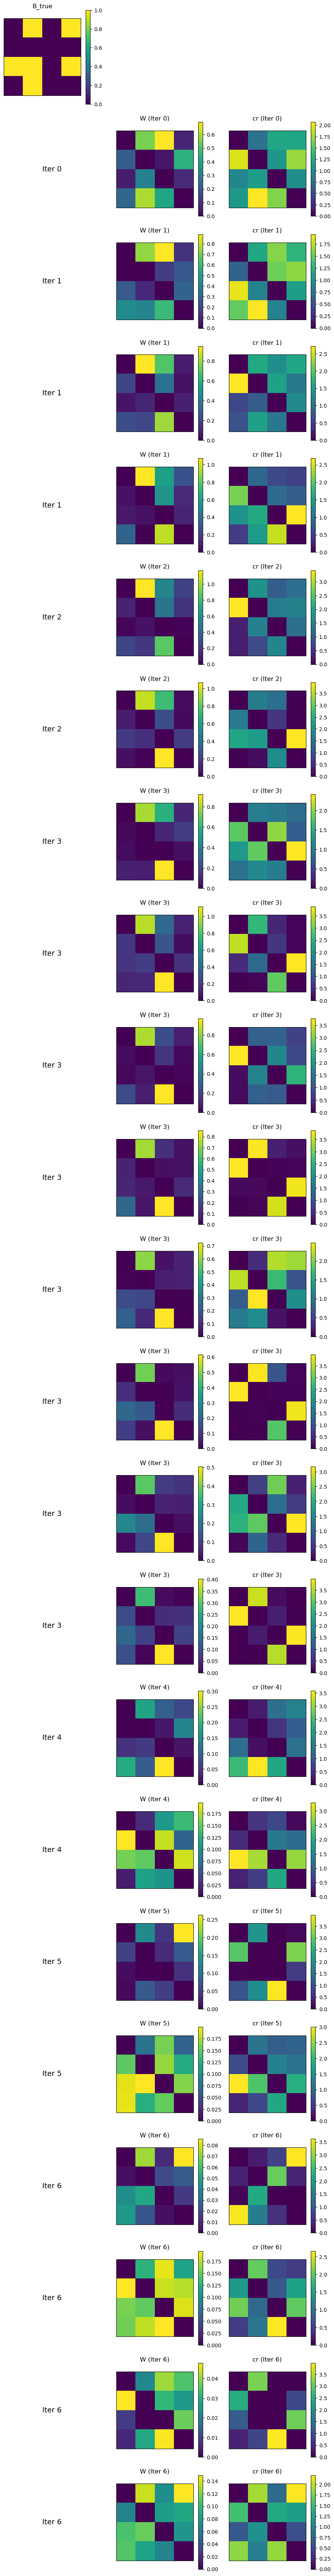

In [46]:
def plot_matrix(ax, matrix, title):
    cax = ax.matshow(matrix, cmap='viridis')
    plt.colorbar(cax, ax=ax)
    ax.set_title(title, pad=20)
    ax.set_xticks([])
    ax.set_yticks([])

def visualize_model(model):
    fig, axes = plt.subplots(len(model['data']) + 1, 3, figsize=(9, 3 * (len(model['data']) + 1)))

    # Plot B_true at the top row
    plot_matrix(axes[0, 0], model['B_true'], "B_true")
    axes[0, 1].axis('off')
    axes[0, 2].axis('off')

    # Plot W and cmp for each iteration in data
    for i, (itern, W, cmp) in enumerate(model['data']):
        row = i + 1
        axes[row, 0].text(0.5, 0.5, f"Iter {itern}", fontsize=14, ha='center', va='center')
        axes[row, 0].axis('off')
        plot_matrix(axes[row, 1], W, f"W (Iter {itern})")
        plot_matrix(axes[row, 2], cmp, f"cr (Iter {itern})")

    plt.tight_layout()
    plt.show()

# Assuming model.vis is available
visualize_model(model.vis)